In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
%matplotlib inline

from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from collections import Counter #키워드 빈도 계산

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# 필요한 데이터 다운로드
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# 데이터 삽입
# 데이터 전처리
# 평점 Best, Worst 긱 10개
# 감정 점수 상하위 각 10개
# 평점 Best 10 리뷰 중 키워드 추출
# 감정 점수 하위 10개 제품 리뷰 중 키워드 추출
# 각 그룹별 리뷰 추출
# 나이대별 리뷰 수 비교
# 나이브 베이즈, 분류 보고서, Confusion matrix, ROC curve

# 데이터셋 삽입 
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone/Womens Clothing E-Commerce Reviews.csv')

# 데이터 확인 
#df.info()      #23486개의 행
#df.describe()
df.head()

# 데이터 전처리
# 결측치 확인 및 제거
#df.isnull().sum()
df.dropna(subset=['Review Text', 'Rating'], inplace=True)
df.isnull().sum()

# # 리뷰의 길이가 10 미만인 경우 삭제
# df = df[df['Review Text'].apply(lambda x: len(x.split()) > 10)]

In [ ]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
# 평점 Best, Worst 10

# 각 제품별 평점(별점) 계산
product_ratings = df.groupby('Clothing ID')['Rating'].mean()

# 인기 제품 상위 10개 추출 (별점순)
top_products = product_ratings.nlargest(10)

# 불만 제품 상위 10개 추출 (별점순)
bottom_products = product_ratings.nsmallest(10)

# 결과 출력
print("인기 제품 상위 10개:\n", top_products)
print("불만 제품 상위 10개:\n", bottom_products)

인기 제품 상위 10개:
 Clothing ID
3     5.0
4     5.0
5     5.0
7     5.0
12    5.0
14    5.0
16    5.0
17    5.0
21    5.0
22    5.0
Name: Rating, dtype: float64
불만 제품 상위 10개:
 Clothing ID
18     1.0
91     1.0
118    1.0
219    1.0
269    1.0
273    1.0
285    1.0
348    1.0
369    1.0
371    1.0
Name: Rating, dtype: float64


In [ ]:
# 감정 점수 상하위 10개

# NLTK의 감정 분석 도구 초기화
sia = SentimentIntensityAnalyzer()

# 리뷰 텍스트를 입력 받아, 감정 점수를 계산하는 함수
def get_sentiment_score(text):
    return sia.polarity_scores(text)['compound']

# 리뷰 내용 감정 점수 계산
df['Sentiment'] = df['Review Text'].apply(lambda x: get_sentiment_score(str(x)))

# 각 제품별 감정 점수 평균 계산
product_sentiments = df.groupby('Clothing ID')['Sentiment'].mean()

# 감정 점수 상위 10개 추출
top_product_sentiments = product_sentiments[top_products.index].nlargest(10)

# 감정 점수 하위 10개 추출 
bottom_product_sentiments = product_sentiments[bottom_products.index].nsmallest(10)

# 결과출력
print("감정 점수 상위 10개 제품 :\n", top_product_sentiments)
print("감정 점수 하위 10개 제품 :\n", bottom_product_sentiments)

감정 점수 상위 10개 제품 :
 Clothing ID
17    0.9611
12    0.9565
14    0.9480
5     0.9123
22    0.9059
4     0.8796
7     0.8674
3     0.8402
21    0.5321
16    0.4111
Name: Sentiment, dtype: float64
감정 점수 하위 10개 제품 :
 Clothing ID
371   -0.7615
369   -0.7390
285   -0.4439
118   -0.4015
273   -0.3200
91     0.0389
18     0.4284
348    0.4854
269    0.5618
219    0.8361
Name: Sentiment, dtype: float64


Top keywords for 3
[('lots', 1), ('compliments', 1)]


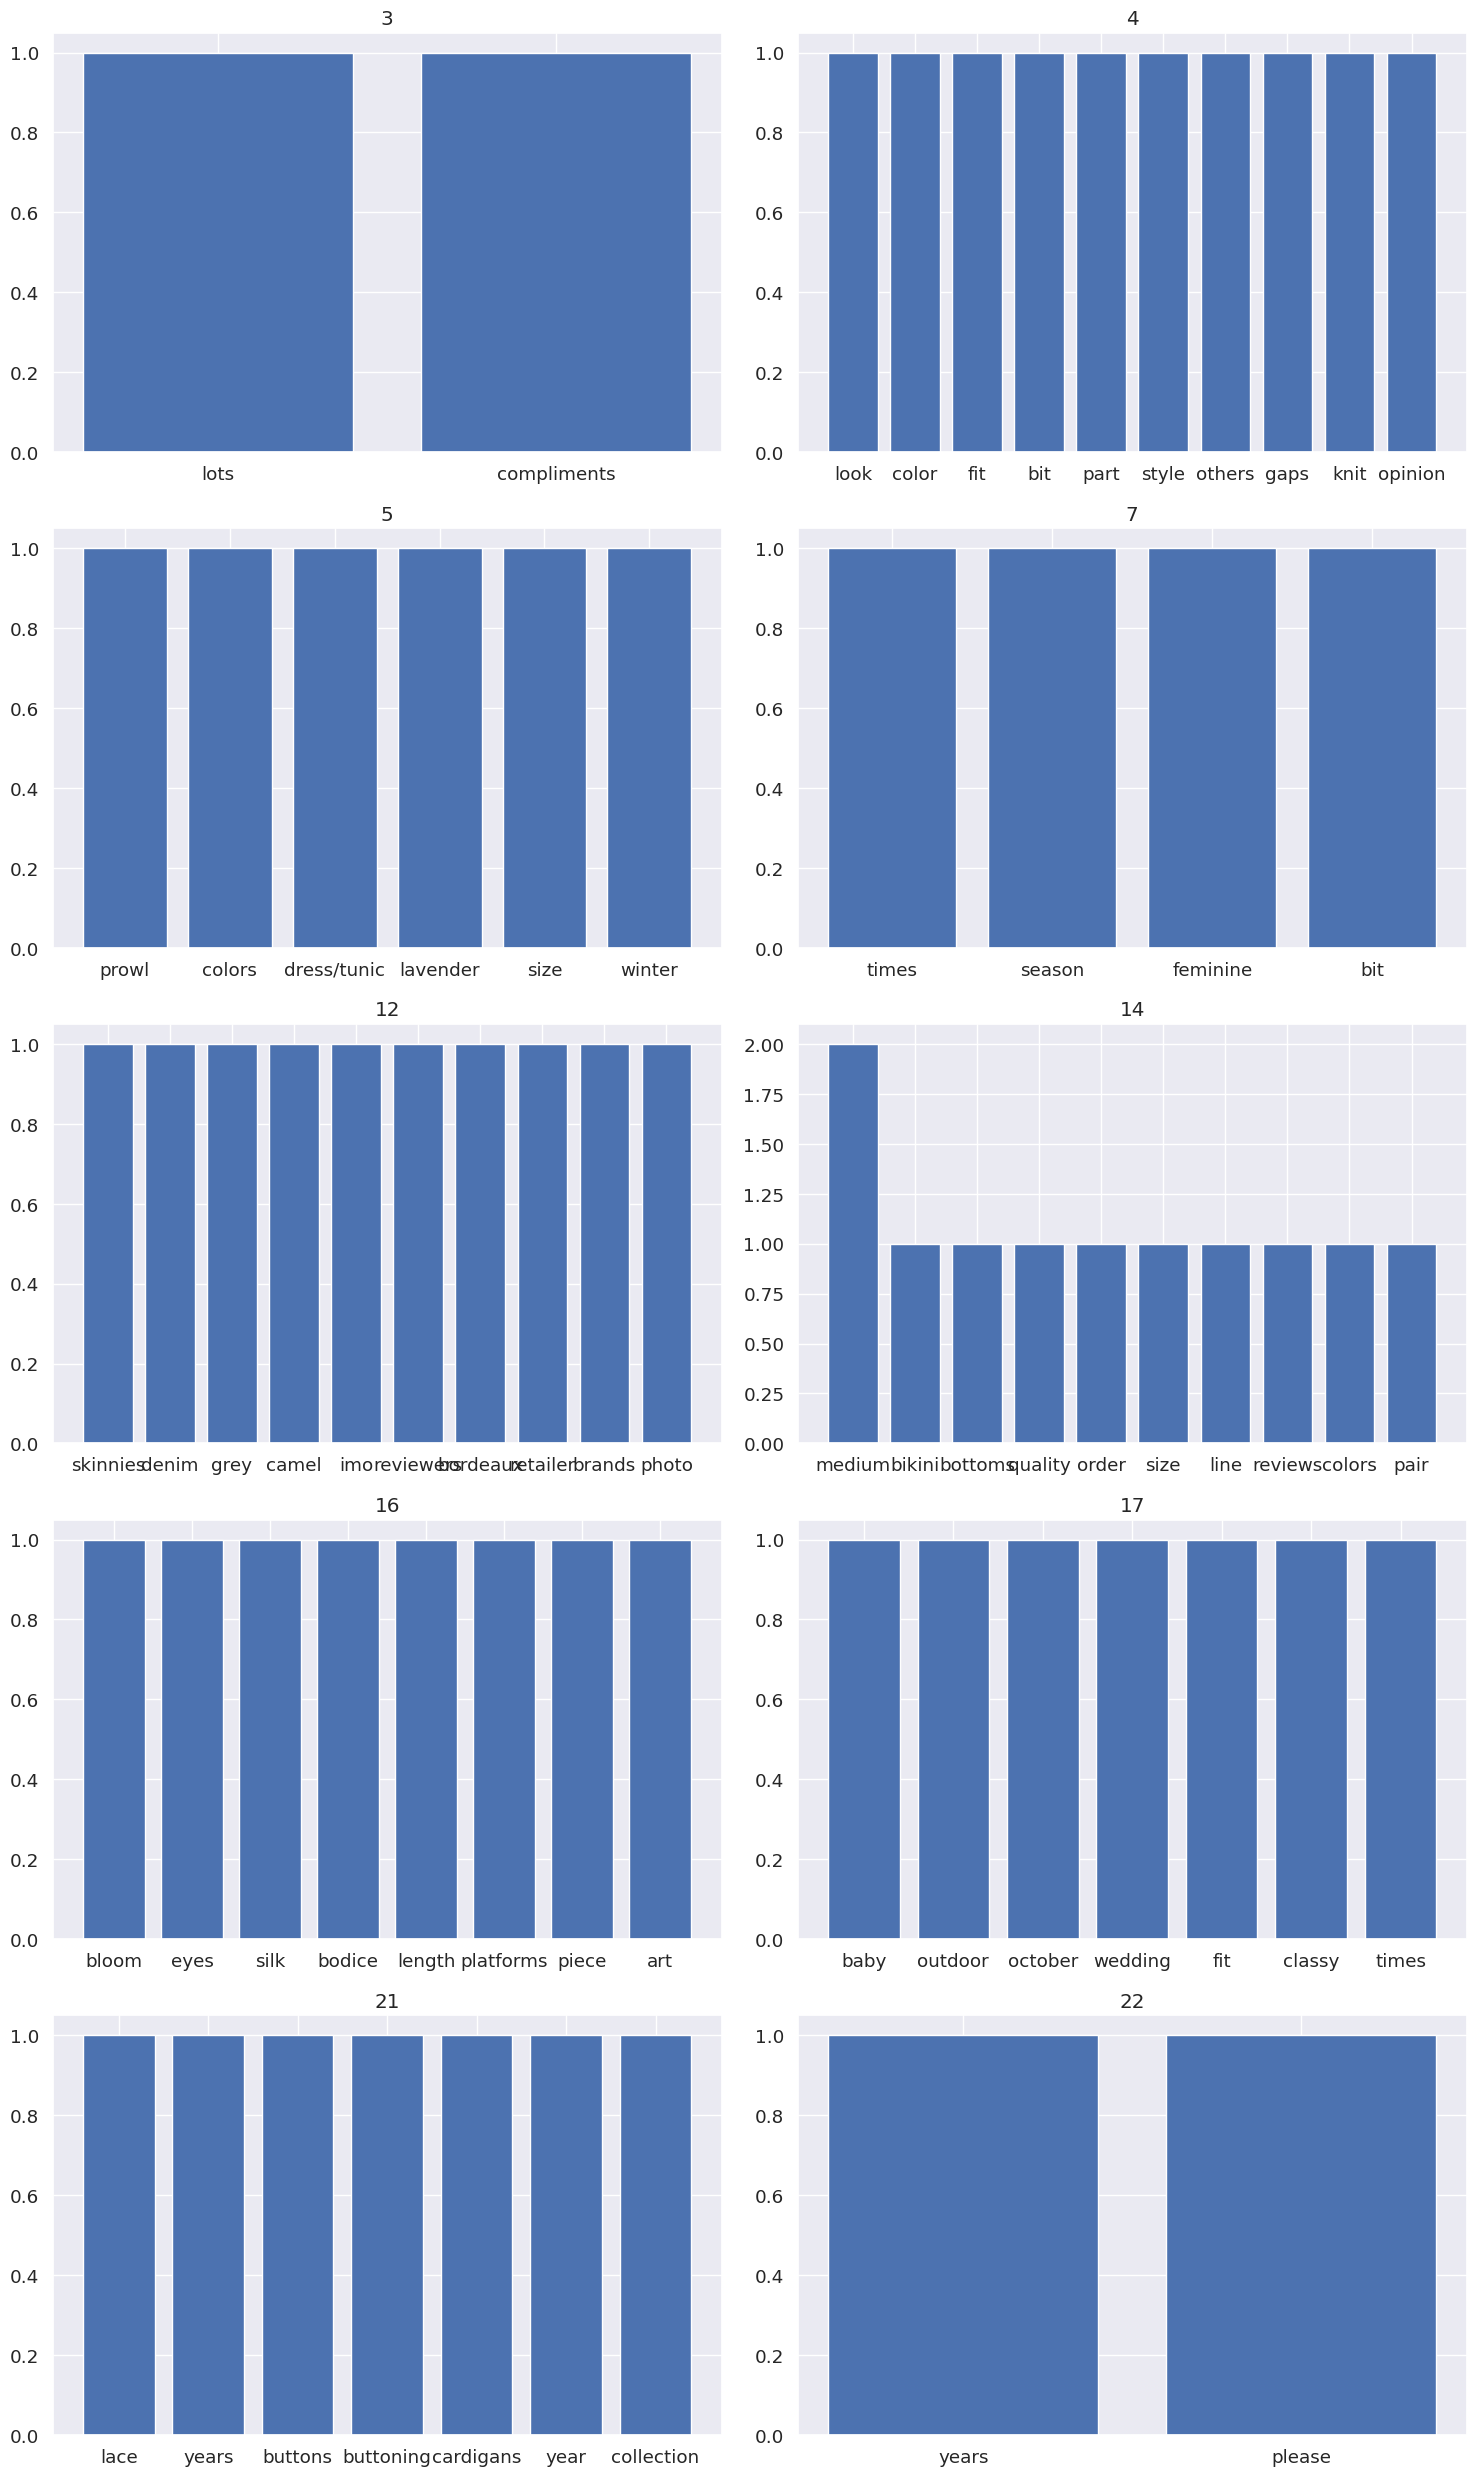

In [ ]:
# 평점 Best 10 리뷰 중 키워드 추출

# 리뷰 추출
top_products_1 = top_products[:10].index.values
top_products_reviews = df[df['Clothing ID'].isin(top_products_1)]['Review Text']

# 불용어 제외 
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords.update(['dress', 'dresses', 'skirt', 'top', 'shirt', 'sweater', 'blouse', 'jacket', 'coat', 
                  'pants', 'jeans', 'shoes', 'bag', 't-shirts', 'cardigan'])

def extract_keywords(text):
    keywords = []
    for word, pos in nltk.pos_tag(word_tokenize(str(text))):
        if pos.startswith('NN') and word.lower() not in stopwords and len(word) > 2:
            keywords.append(word.lower())
    return keywords

# 키워드 빈도 계산
top_products_keywords = []
for review in top_products_reviews:
    keywords = extract_keywords(review)
    top_products_keywords.extend(keywords)

top_products_keyword_counts = {}
for product in top_products_1:
    product_reviews = df[df['Clothing ID'] == product]['Review Text']
    product_keywords = []
    for review in product_reviews:
        keywords = extract_keywords(review)
        product_keywords.extend(keywords)
    top_products_keyword_counts[product] = Counter(product_keywords)

# 빈도 출력
print(f"Top keywords for {df[df['Clothing ID'] == top_products_1[0]]['Clothing ID'].iloc[0]}")
print(top_products_keyword_counts[top_products_1[0]].most_common(10))

# 시각화
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for i, product in enumerate(top_products_1):
    ax = axes[i//2, i%2]
    ax.bar(*zip(*top_products_keyword_counts[product].most_common(10)))
    ax.set_title(df[df['Clothing ID'] == product]['Clothing ID'].iloc[0])
    
plt.tight_layout()
plt.show()

Top keywords for 371
[('cute', 1), ('wasnt', 1), ('sewn', 1), ('waistband', 1), ('mess', 1), ('loungewear', 1)]


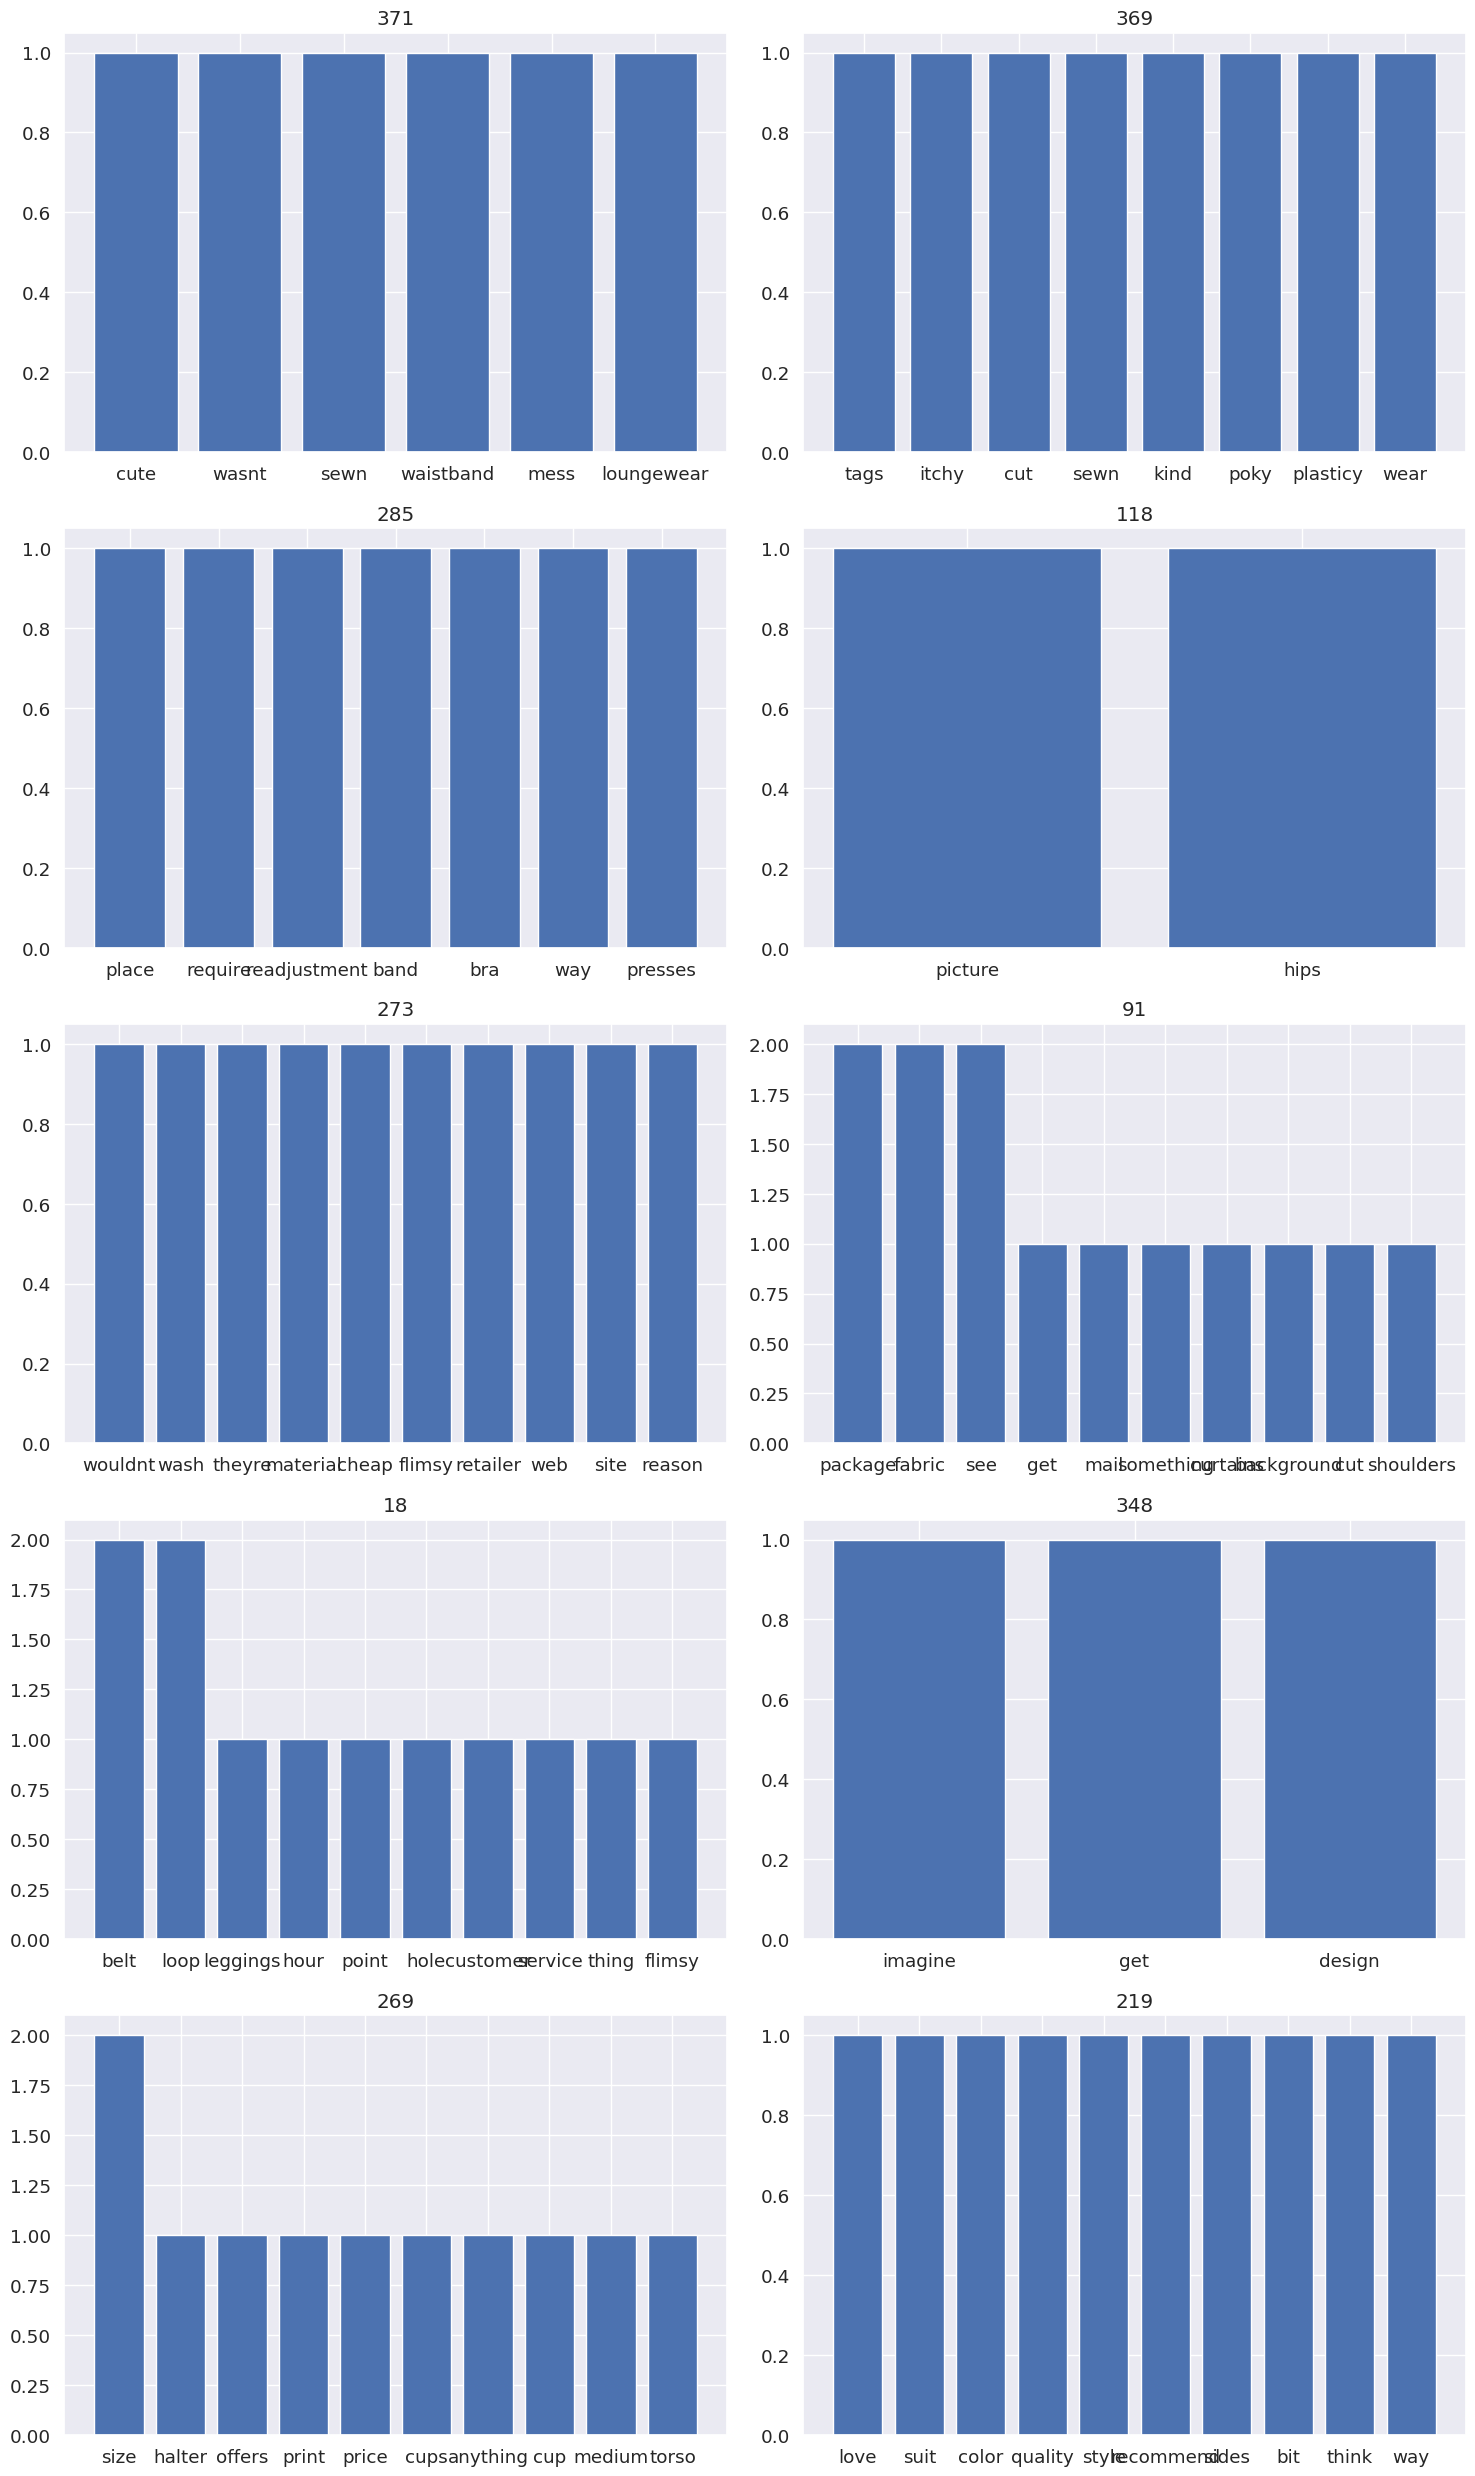

In [ ]:
# 감정 점수 하위 10개 제품 리뷰 중 키워드 추출

# 리뷰 추출
bottom_product_sentiments_1 = bottom_product_sentiments[:10].index.values
top_products_reviews = df[df['Clothing ID'].isin(bottom_product_sentiments_1)]['Review Text']


# 키워드 빈도 계산
top_products_keywords = []
for review in top_products_reviews:
    keywords = extract_keywords(review)
    top_products_keywords.extend(keywords)

top_products_keyword_counts = {}
for product in bottom_product_sentiments_1:
    product_reviews = df[df['Clothing ID'] == product]['Review Text']
    product_keywords = []
    for review in product_reviews:
        keywords = extract_keywords(review)
        product_keywords.extend(keywords)
    top_products_keyword_counts[product] = Counter(product_keywords)

# 빈도 출력
print(f"Top keywords for {df[df['Clothing ID'] == bottom_product_sentiments_1[0]]['Clothing ID'].iloc[0]}")
print(top_products_keyword_counts[bottom_product_sentiments_1[0]].most_common(10))

# 시각화
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for i, product in enumerate(bottom_product_sentiments_1):
    ax = axes[i//2, i%2]
    ax.bar(*zip(*top_products_keyword_counts[product].most_common(10)))
    ax.set_title(df[df['Clothing ID'] == product]['Clothing ID'].iloc[0])
    
plt.tight_layout()
plt.show()

In [ ]:
# 각 그룹별 리뷰 추출

# # 인기 상품 상위 10개 찾기
# top_products = df.groupby('Clothing ID')['Rating'].mean().sort_values(ascending=False).head(10)
# top_products = df.loc[df['Clothing ID'].isin(top_products.index)]

# # 인기 상품 상세 분석
# for i, row in top_products.iterrows():
#     print('Clothing ID:', row['Clothing ID'])
#     print('Rating:', row['Rating'])
#     print('Review Text:', row['Review Text'])
#     print('-' * 50)

# 불만족 상품 상위 10개 찾기
bottom_product_sentiments_2 = df.groupby('Clothing ID')['Rating'].mean().sort_values().head(10)
bottom_product_sentiments_2 = df.loc[df['Clothing ID'].isin(bottom_product_sentiments_2.index)]

# 불만족 상품 상세 분석
for i, row in bottom_product_sentiments_2.iterrows():
    print('Clothing ID:', row['Clothing ID'])
    print('Rating:', row['Rating'])
    print('Review Text:', row['Review Text'])
    print('-' * 50)

Clothing ID: 285
Rating: 1
Review Text: seemed stay place require constant readjustment however found band extremely small tight comfortable bra way band presses skin
--------------------------------------------------
Clothing ID: 973
Rating: 1
Review Text: even deep discount piece definitely worth money picture made think jacket longer curved velvet hem part design would coolwhich largely attracted discovered arrived actually part shirt worn beneath photo image rather misleading actual jacket thinmore like shirt open front jacket pockets loosely tacked inside
--------------------------------------------------
Clothing ID: 118
Rating: 1
Review Text: long picture hit hips good
--------------------------------------------------
Clothing ID: 219
Rating: 1
Review Text: wanted love suit gorgeous color quality style returning recommend sides need connected little bit higher think would work way could move around without things popping front mean would gorgeous lay sun didnt feel like could e

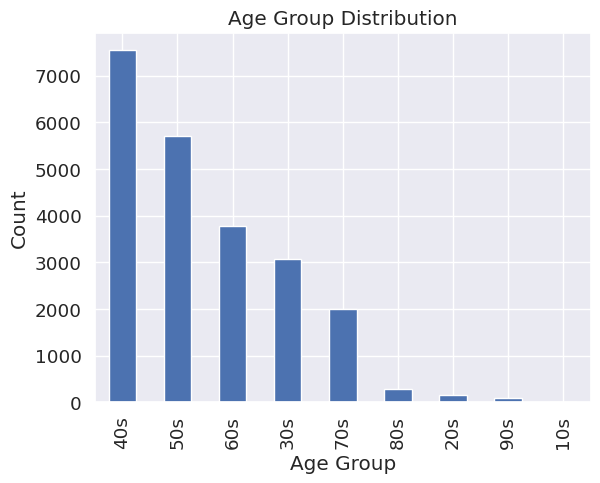

In [ ]:
# 나이대별 리뷰 수 비교

# # 리뷰 작성자의 나이 정보가 담긴 컬럼 추출
# age_col = df['Age'] 
# # 각 나이별 리뷰 개수 계산
# age_counts = age_col.value_counts()
# print("나이별 리뷰 개수:\n", age_counts)

# 나이대 열 추가 - 시각화를 위하여 나이대(10대, 20대 등)로 분류
df["Age Group"] = pd.cut(df["Age"], bins=range(0, 100, 10), labels=["{}s".format(i) for i in range(10, 100, 10)])

# 나이대별 리뷰 개수 계산
age_counts = df["Age Group"].value_counts()

# 시각화
age_counts.plot(kind="bar")
plt.title("Age Group Distribution")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()

In [16]:
# 카테고리 기준
def category_analysis(df):
categories = df['Class Name'].unique()
    category_review_count = {}
    category_rating = {}
    category_review_ratio = {}
    for category in categories:
        category_review_count[category] = df[df['Class Name'] == category]['Review Text'].count()
        category_rating[category] = df[df['Class Name'] == category]['Rating'].mean()
        category_review_ratio[category] = category_review_count[category] / df[df['Class Name'] == category]['Clothing ID'].nunique()
    return pd.DataFrame({'Number of Reviews': category_review_count, 'Average Rating': category_rating, 'Review Ratio': category_review_ratio}).sort_values(by='Number of Reviews', ascending=False)
category_analysis(df)

<ipython-input-16-478909ddc2a4>:10: RuntimeWarning: invalid value encountered in long_scalars
  category_review_ratio[category] = category_review_count[category] / df[df['Class Name'] == category]['Clothing ID'].nunique()


,Number of Reviews,Average Rating,Review Ratio
Dresses,6145,4.138812,97.539683
Knits,4626,4.145698,100.565217
Blouses,2983,4.142809,74.575000
Sweaters,1380,4.168841,37.297297
Pants,1350,4.261481,27.000000
Jeans,1104,4.347826,46.000000
Fine gauge,1059,4.237960,31.147059
Skirts,903,4.229236,25.800000
Jackets,683,4.288433,20.696970
Lounge,669,4.301943,3.054795


<ipython-input-62-31afedf9f177>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Sentiment'] = df1['Rating'].apply(lambda x: 1 if x >= 4 else 0)


              precision    recall  f1-score   support

           0       0.93      0.06      0.12      1045
           1       0.78      1.00      0.88      3484

    accuracy                           0.78      4529
   macro avg       0.85      0.53      0.50      4529
weighted avg       0.81      0.78      0.70      4529



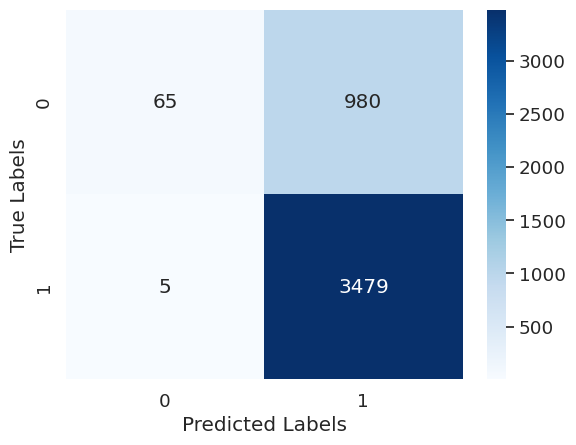

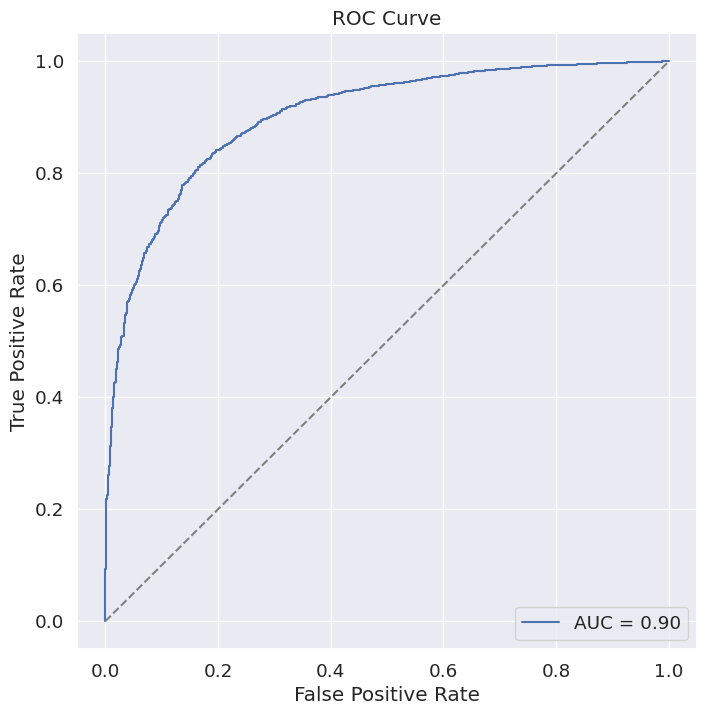

In [ ]:
# 나이브 베이즈, 분류 보고서, Confusion matrix, ROC curve

# 필요한 열 추출
df1 = df[['Review Text', 'Rating']]

# 평점 기준으로 긍정(1)/부정(0) 레이블 생성
df1['Sentiment'] = df1['Rating'].apply(lambda x: 1 if x >= 4 else 0)

# 전처리 함수 정의 - 리뷰 텍스트 정제 및 벡터화화
def preprocess_text(text):
    # 구두점 제거
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # 소문자 변환
    text = text.lower()
    
    # 토큰화
    tokens = word_tokenize(text)
    
    # 알파벳으로만 이루어진 토큰 추출 (특수문자 제거거)
    tokens = [word for word in tokens if word.isalpha()]
    
    # 불용어 제거
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if not word in stop_words]
    
    # 어간 추출
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)

# 텍스트 전처리
df['Review Text'] = df['Review Text'].apply(preprocess_text)

# TF-IDF 벡터화
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df1['Review Text'])
y = df1['Sentiment']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 나이브 베이즈 모델 학습
nb = MultinomialNB()
nb.fit(X_train, y_train)

# 예측값 생성
y_pred = nb.predict(X_test)

# 분류 보고서 및 confusion matrix 출력
print(classification_report(y_test, y_pred))
confusion_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# # 정확도 계산
# accuracy = accuracy_score(y_test, y_pred)
# print('Accuracy:', accuracy)

# ROC curve 그리기
y_prob = nb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

# ROC Curve 시각화
sns.set(font_scale=1.2)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()